<a href="https://colab.research.google.com/github/Tyred/TimeSeries_OCC-PUL/blob/main/Notebooks/OC_ConvAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> One-Class Classification Using Convolutional Autoencoders </h1>

The main idea is to train a CAE (Convolutional Autoencoder) with data from the positive class only and calculate a reconstruction error threshold T based on the reconstruction errors obtained during the training. <br/>
Then we perform the One-Class Classification (OCC) as follows:

- For each data sample in the test dataset, do:
    - Reconstruct the data with the CAE and calculate its reconstruction error E.
    - if E <= T the sample is classified as a member of the positive class.
    - else (if E > T) the sample is classified as not a member of the positive class.  

- Evaluate the Model's Accuracy, Precision and Recall.

## Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

# Autoencoders

## Convolutional Using MaxPooling
- Subclassing

In [2]:
# Convolutional Autoencoder with MaxPooling:
class ConvAutoencoder(tf.keras.Model):
    def __init__(self): #, serie_length):
        super(ConvAutoencoder, self).__init__()
        self.conv_1  = keras.layers.Conv1D(16, 3, activation='swish', padding='same') #, input_shape=(serie_length))
        self.max_1   = keras.layers.MaxPooling1D(2)
        self.conv_2  = keras.layers.Conv1D(32, 3, activation='swish', padding='same')
        self.max_2   = keras.layers.MaxPooling1D(2)
        self.conv_3  = keras.layers.Conv1D(64, 3, activation='swish', padding='same')
        
        # encoded representation
        self.encoded = keras.layers.MaxPooling1D(2, padding='same')
        
        # decoder layers
        self.conv_4  = keras.layers.Conv1D(64, 3, activation='swish', padding='same')
        self.up_1    = keras.layers.UpSampling1D(2)
        self.conv_5  = keras.layers.Conv1D(32, 3, activation='swish', padding='same')
        self.up_2    = keras.layers.UpSampling1D(2)
        self.conv_6  = keras.layers.Conv1D(16, 3, activation='swish', padding='same')
        self.up_3    = keras.layers.UpSampling1D(2)
        
        # decoded output
        self.decoded = keras.layers.Conv1D(1, 3, activation='linear', padding='same')

    def encoder(self, inputs):
        if self.padding != 0:
            inputs = keras.layers.ZeroPadding1D(padding=(8 + 8-self.padding, 0))(inputs)
        x = self.conv_1(inputs)
        x = self.max_1(x)
        x = self.conv_2(x)
        x = self.max_2(x)
        x = self.conv_3(x)
        return self.encoded(x)
    
    def decoder(self, inputs):
        #x = self.encode(inputs)
        x = self.conv_4(inputs)
        x = self.up_1(x)
        x = self.conv_5(x)
        x = self.up_2(x)
        x = self.conv_6(x)
        x = self.up_3(x)
        if self.padding != 0:
            x = keras.layers.Cropping1D(cropping=(8 + 8-self.padding, 0))(x)
        return self.decoded(x)
     
    def call(self, inputs):
        self.padding = inputs.shape[1] % 8
        _encoded = self.encoder(inputs)
        _decoded = self.decoder(_encoded)

        return _decoded

    def model(self):
        x = keras.layers.Input(shape=(serie_length, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

# Reading Dataset from Google Drive

In [3]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')
tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", 
                        delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", 
                        delimiter="\t",)

labels = te_data[:, 0]
print("Labels:", np.unique(labels))

Dataset: FordA
Labels: [-1.  1.]


# Splitting in Train-Test data

In [4]:
class_label = int(input('Positive class label: '))

train_data  = tr_data[tr_data[:, 0] == class_label, 1:] # train
test_data   = te_data[:, 1:]                            # test
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

train_data = tf.cast(train_data, tf.float32)
test_data  = tf.cast(test_data , tf.float32)

train_data = tf.expand_dims(train_data, axis=-1)
test_data  = tf.expand_dims(test_data , axis=-1)

serie_length = train_data.shape[1]

Positive class label: 1
Train data shape: (1755, 500)
Test data shape: (1320, 500)


# Labeling for OCC Task

In [5]:
occ_labels = [1 if x == class_label else 0 for x in labels]
print("Positive samples:", occ_labels.count(1))
print("Negative samples:", occ_labels.count(0))

positive_test_data = test_data[np.array(occ_labels).astype(bool)]
negative_test_data = test_data[~np.array(occ_labels).astype(bool)]

Positive samples: 639
Negative samples: 681


# Initializing and training the Conv Autoencoder

In [6]:
autoencoder = ConvAutoencoder() 

In [7]:
autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
# Train
batch_size = 32
epochs = 50

history = autoencoder.fit(train_data, train_data, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_data=(test_data, test_data))

Epoch 1/50
55/55 [==============================] - 35s 30ms/step - loss: 0.2883 - val_loss: 0.1047
Epoch 2/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0431 - val_loss: 0.0684
Epoch 3/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0217 - val_loss: 0.0430
Epoch 4/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0144 - val_loss: 0.0352
Epoch 5/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0119 - val_loss: 0.0298
Epoch 6/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0101 - val_loss: 0.0255
Epoch 7/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0085 - val_loss: 0.0217
Epoch 8/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0072 - val_loss: 0.0185
Epoch 9/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0060 - val_loss: 0.0158
Epoch 10/50
55/55 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0136
Epoch 11

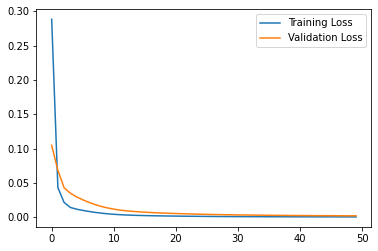

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [10]:
autoencoder.model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 512, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 256, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 32)           1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 64)           6208  

# Reconstruction examples

## Positive Class

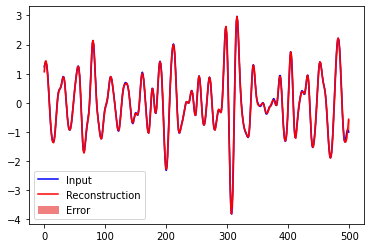

In [11]:
encoded_data = autoencoder.encoder(positive_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy().squeeze()

plt.plot(positive_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(serie_length), decoded_data[0], 
                 np.squeeze(positive_test_data[0]), color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Negative Class

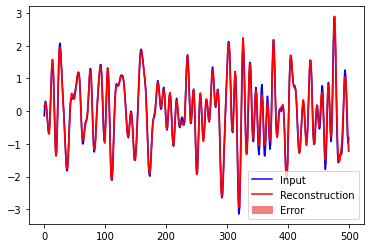

In [12]:
encoded_data = autoencoder.encoder(negative_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy().squeeze()

plt.plot(negative_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(serie_length), decoded_data[0], 
                 np.squeeze(negative_test_data[0]), color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# Reconstruction Error Histogram

## Train 

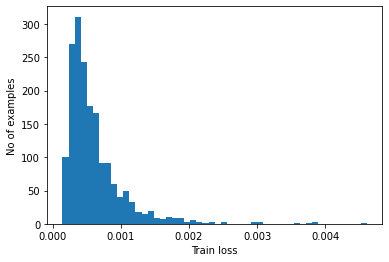

In [13]:
reconstructions = autoencoder.predict(train_data).squeeze()
train_loss = tf.keras.losses.mse(reconstructions, train_data.numpy().squeeze())

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## Test - Negative Class

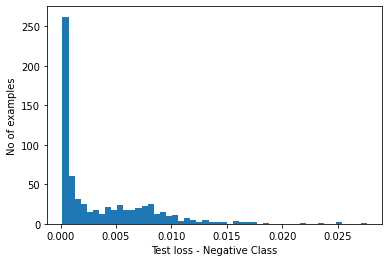

In [14]:
reconstructions = autoencoder.predict(negative_test_data).squeeze()
negative_test_loss = tf.keras.losses.mse(reconstructions, 
                                 negative_test_data.numpy().squeeze())

plt.hist(negative_test_loss[None,:], bins=50)
plt.xlabel("Test loss - Negative Class")
plt.ylabel("No of examples")
plt.show()

## Test - Positive Class

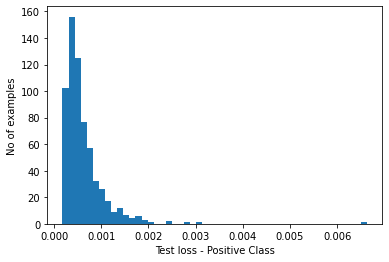

In [15]:
reconstructions = autoencoder.predict(positive_test_data).squeeze()
positive_test_loss = tf.keras.losses.mse(reconstructions, 
                                 positive_test_data.numpy().squeeze())

plt.hist(positive_test_loss[None,:], bins=50)
plt.xlabel("Test loss - Positive Class")
plt.ylabel("No of examples")
plt.show()

# Threshold Definition and OCC Task








In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0010213718


In [20]:
def predict(model, data, threshold):
  reconstructions = model(data)
  reconstructions = reconstructions.numpy().squeeze()
  data = data.numpy().squeeze()
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less_equal(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = %.2f"  % (accuracy_score(labels, predictions)  *100) + "%")
  print("Precision = %.2f" % (precision_score(labels, predictions) *100) + "%")
  print("Recall = %.2f"    % (recall_score(labels, predictions)    *100) + "%")
  print("F1-Score = %.2f"  % (f1_score(labels, predictions)        *100) + "%")

In [21]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, occ_labels)

Accuracy = 71.82%
Precision = 65.47%
Recall = 88.42%
F1-Score = 75.23%
